# Regularization

This document focuses on regularization, a method used to reduce the coefficients of the machine learning models.

In [14]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder

Suppose we have a parametric machine learning model with weights $W = \left(w_1, w_2, \ldots, w_n\right)$ that needs to be fitted. It is supposed to be fitted with an $L$ loss function. In such case:

- L1 regularization (lasso) is supposed to use the loss function $L'(W) = L(W) + \lambda\sum_{i=1}^n |w_i|$.
- L2 regularization (ridge) is supposed to use the loss function $L'' = L(W) + \lambda\sum_{i=1}^n w_i^2$.

Here, $\lambda \geq 0$ is a parameter that defines the strength of the regularization.

## Compression example

This section reproduces example from the [ISLR](https://www.statlearning.com/).

Following cell loads and prepares data.

In [15]:
Credit = pd.read_csv("regularization_files/Credit.csv", index_col = 0)

nominal_names = ["Gender", "Student", "Married", "Ethnicity"]

ohe = OneHotEncoder(
    sparse_output = False, drop = "first"
).fit(
    Credit[nominal_names]
)

Credit = pd.concat(
    [
        pd.DataFrame(
            np.array(ohe.transform(Credit[nominal_names])),
            columns = ohe.get_feature_names_out(),
            index= Credit.index
        ),
        Credit.loc[:,~Credit.columns.isin(nominal_names)]
    ],
    axis = 1
)

X = Credit.iloc[:,:-1]
y = Credit.iloc[:, -1]

Credit.head()

,Gender_Female,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian,Income,Limit,Rating,Cards,Age,Education,Balance
ID,,,,,,,,,,,,
1,0.0,0.0,1.0,0.0,1.0,14.891,3606,283,2,34,11,333
2,1.0,1.0,1.0,1.0,0.0,106.025,6645,483,3,82,15,903
3,0.0,0.0,0.0,1.0,0.0,104.593,7075,514,4,71,11,580
4,1.0,0.0,0.0,1.0,0.0,148.924,9504,681,3,36,11,964
5,0.0,0.0,1.0,0.0,1.0,55.882,4897,357,2,68,16,331


The following cell computes the coefficients of Lasso regression as the value of $\lambda$ is gradually increased.

In [24]:
coefs_frame = dict[float, pd.Series]()

stand_X = X / np.sqrt(((X - X.mean()) ** 2).sum() / X.shape[0])

alphas = np.arange(0, 2000, 0.1)
int_count = len(alphas)

for i, alpha in enumerate(tqdm(alphas)):
    coefs_frame[float(alpha)] = pd.Series(
        Ridge(alpha = alpha).fit(stand_X,y).coef_,
        index = X.columns
    )

coefs_frame = pd.DataFrame(coefs_frame).T
coefs_frame.index.name = "alpha"

100%|██████████| 20000/20000 [00:30<00:00, 662.32it/s]


The obtained values of coefficients are plotted on the graphs.

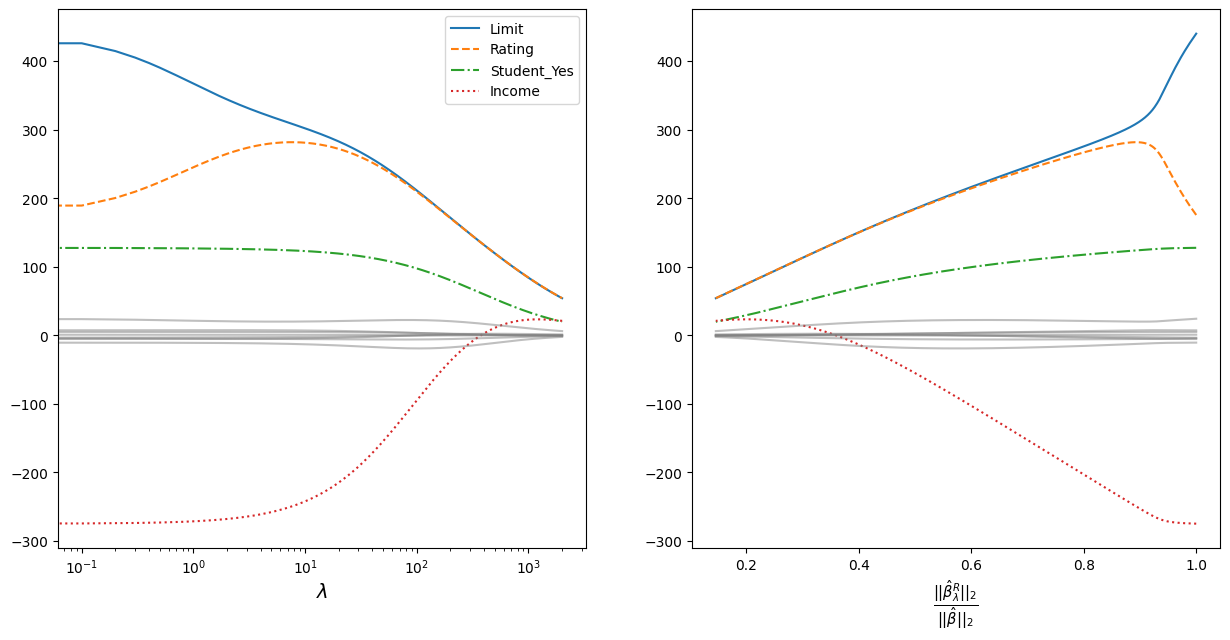

In [23]:
coefs_frame = pd.read_csv("regularization_files/l2_reg_coefs.csv", index_col = 0)

plot_var_names = ["Limit", "Rating", "Student_Yes", "Income"]
line_styles = ['-', '--', '-.', ':']

beta_0 = np.sqrt(np.sum(coefs_frame.loc[0]**2))
coefs_frame["beta_i/beta_0"] = coefs_frame.apply(
    lambda row: np.sqrt(np.sum(row**2))/beta_0,
    axis = 1
)

plt.figure(figsize = [15, 7])
plt.subplot(121)

for i in range(len(plot_var_names)):
    plt.plot(
        coefs_frame.index, 
        coefs_frame[plot_var_names[i]],
        linestyle = line_styles[i]
    )
    
for col in coefs_frame.loc[
    :, ~coefs_frame.columns.isin(plot_var_names)
]:
    plt.plot(
        coefs_frame.index, coefs_frame[col], 
        color = "gray", alpha = 0.5
    )
    
plt.legend(plot_var_names)
plt.xlabel("$\\lambda$", fontsize = 14)
    
plt.gca().set_xscale("log")

plt.subplot(122)

for i in range(len(plot_var_names)):
    plt.plot(
        coefs_frame["beta_i/beta_0"], 
        coefs_frame[plot_var_names[i]],
        linestyle = line_styles[i]
    )
    
for col in coefs_frame.loc[
    :, ~coefs_frame.columns.isin(plot_var_names)
]:
    plt.plot(
        coefs_frame["beta_i/beta_0"], coefs_frame[col], 
        color = "gray", alpha = 0.5
    )

ans = plt.xlabel(
    "$\\frac{||\\hat{\\beta}_{\\lambda}^R||_2}{||\\hat{\\beta}||_2}$",
    fontsize = 15
)

- The graph on the left shows how the coefficients converge as the regularisation parameter increases. For clarity, a logarithmic scale for the regularisation parameter is taken. The most prominent coefficients are highlighted in colour and line style - the data are standardised, so the scale of the values does not matter;
- The vergence is plotted to the right on the ordinate:

$$\frac{||\hat{\beta}_{\lambda}^R|_2}{||\hat{\beta}||_2}$$

Where:
- $||\beta||_2 = \sqrt{\sum_{j=1}^p \beta^2_j}$ - is the Euclidean distance of the coefficients $\beta$ from the origin;
- $\hat{\beta}$ - coefficients obtained by the least squares method (equivalent to the coefficients obtained at $\lambda = 0$);
- $\hat{\beta}^R_{\lambda}$ - coefficients obtained using regularisation.

## Alternative definition

Due to Lagrangean duality optimization tasks in regularization can be redefined.

In **L1 regularaztion** case, the solution to the optimization problem

$$
\min_{W \in \mathbb{R}^n} \; L(W) + \lambda \sum_{i=1}^n |w_i|
$$

is equivalent to the solution of the problem

$$
\min_{W \in \mathbb{R}^n} \; L(W)
$$

subject to the constraint

$$
\sum_{i=1}^n |w_i| \leq s,
$$

where $s \geq 0$ is a constraint bound. The equivalence holds under appropriate choices of $\lambda$ and $s$, which correspond to one another via duality.

Analogically in **L2 regularization** case:

$$
\min_{W \in \mathbb{R}^n} \; L(W) + \lambda \sum_{i=1}^n w_i^2.
$$

is equivalent to the solution of the problem

$$\min_{W \in \mathbb{R}^n} L(W)$$

subject to the constraint

$$
\sum_{i=1}^n w_i^2 \leq s.
$$

## L1 coefficients pruning

The lasso method typically results in unimportant coefficients being set to zero. This section explores the reasons.

The following picture illustrates the dual optimization tasks for L1 (left) and L2 (right) regularization in the two-dimensional case.

<svg width=500 height=500 viewBox="-12 -40 60 60" style="font-family: 'LatinModern'" font-style="italic" font-size="2">
<path d="M 10 0 L 0 -10 -10 0 0 10" fill="green"/>
<line x1="-12" y1="0" x2="20" y2="0" stroke="black" stroke-width="0.3"/>
<line x1="0" y1="-20" x2="0" y2="12" stroke="black" stroke-width="0.3"/>
<path d="M 19 0.5 L 20 0 19 -0.5"/>
<text x="19" y="2">w1</text>
<path d="M 0.5 -19 L 0 -20 -0.5 -19"/>
<text x="1" y="-18">w2</text>
<circle cx="10" cy="-20" r="0.5" fill="red"/>
<ellipse cx="10" cy="-20" rx="14" ry="4.666" stroke-width="0.3" stroke="black" fill="none" transform="rotate(-45, 10, -20)"/>
<ellipse cx="10" cy="-20" rx="9" ry="3" stroke-width="0.3" stroke="black" fill="none" transform="rotate(-45, 10, -20)"/>
<ellipse cx="10" cy="-20" rx="6" ry="2" stroke-width="0.3" stroke="black" fill="none" transform="rotate(-45, 10, -20)"/>
</svg>

<svg width=500 height=500 viewBox="-12 -40 60 60" style="font-family: 'LatinModern'" font-style="italic" font-size="2">
<circle cx=0 cy=0 r=10 fill="green"/>
<line x1="-12" y1="0" x2="20" y2="0" stroke="black" stroke-width="0.3"/>
<line x1="0" y1="-20" x2="0" y2="12" stroke="black" stroke-width="0.3"/>
<path d="M 19 0.5 L 20 0 19 -0.5"/>
<text x="19" y="2">w1</text>
<path d="M 0.5 -19 L 0 -20 -0.5 -19"/>
<text x="1" y="-18">w2</text>
<circle cx="10" cy="-20" r="0.5" fill="red"/>
<ellipse cx="10" cy="-20" rx="13.5" ry="4.5" stroke-width="0.3" stroke="black" fill="none" transform="rotate(-45, 10, -20)"/>
<ellipse cx="10" cy="-20" rx="9" ry="3" stroke-width="0.3" stroke="black" fill="none" transform="rotate(-45, 10, -20)"/>
<ellipse cx="10" cy="-20" rx="6" ry="2" stroke-width="0.3" stroke="black" fill="none" transform="rotate(-45, 10, -20)"/>
</svg>

The green area shows the constraint, and the contour shows the original loss function without any additional components related to the regularization.

This picture shows that the diamond-shaped constraint associated with L1 regularization is more likely to lead to solutions where some learnable parameters become zero.

The following section examines the properties of the loss function under linear dependency among predictors and explores the implications for solutions subject to L1 and L2 regularization constraints.

Consider how the linear dependency of the predictors influences the optimization problem subject to the constraints associated with L1 and L2 regularization.

The following code generates a set of two-dimensional linear regression problems. The problems are constructed so that the predictors exhibit varying degrees of linear dependence. The influence of the second variable on the target is noisy, making it more likely to be excluded by any dimensionality-reducing method.

In [ ]:
import numpy as np 

import matplotlib.axes
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Patch, Circle

sample_size = 200
np.random.seed(10)
x1 = np.random.random(sample_size)
dependence_range = np.array([0, 0.2, 0.6, 0.8])[:, None]
x2 = (
    (x1 * dependence_range) +
    (np.random.random(sample_size) * (1 - dependence_range))
)

y = (5*x1 + 5*x2)


X = np.stack([
    np.repeat(x1[None, :], len(x2), axis=0),
    x2  + np.random.normal(0, 0.3, sample_size)]
)

W = np.stack(np.meshgrid(
    np.linspace(-5, 10, 500),
    np.linspace(-5, 10, 500)
))
y_hat = np.tensordot(X, W, axes=(0, 0))
MSE = ((y_hat - y[..., None, None])**2).mean(axis=1)

The picture below illustrates the relationship between the predictors in the considered regression tasks.

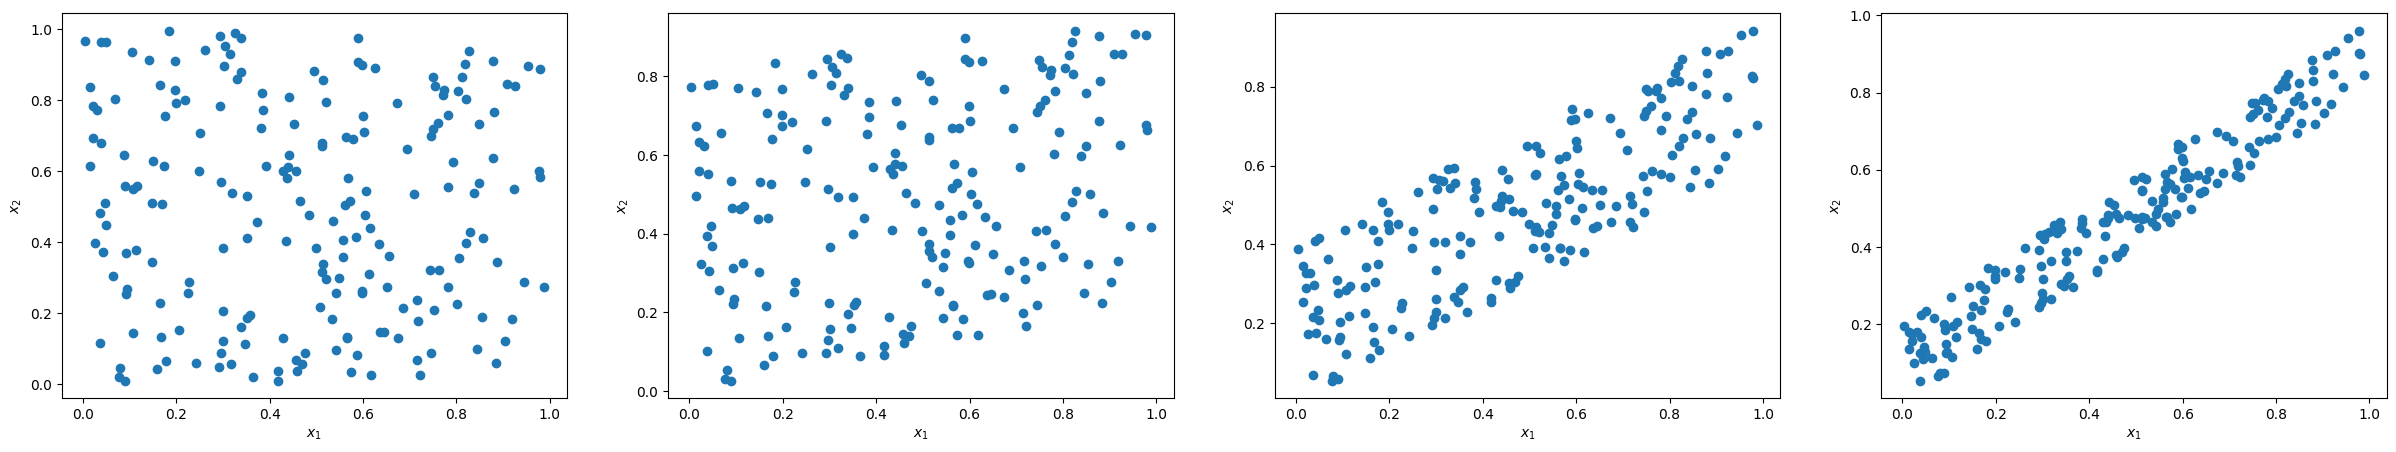

In [ ]:
plt.figure(figsize=(30, 5))

for i in range(len(x2)):
    plt.subplot(1, len(x2), i + 1)
    plt.scatter(x1, x2[i])
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

The next code creates a set of visualizations that illustrate optimization problems for regression tasks with low and hight dependency between predictors, from left to right.

In [ ]:
W = np.stack(np.meshgrid(
    np.linspace(-5, 10, 500),
    np.linspace(-5, 10, 500)
))
y_hat = np.tensordot(X, W, axes=(0, 0))
MSE = ((y_hat - y[..., None, None])**2).mean(axis=1)

def draw_loss_contour(
    ax: matplotlib.axes.Axes,
    W0: np.ndarray,
    W1: np.ndarray,
    L: np.ndarray,
    conjuction: Patch
):
    ax.contour(
        W0, W1, L, 
        levels=np.quantile(L, np.linspace(0, 0.5, 7))
    )
    ax.set_xlabel("$w_1$")
    ax.set_ylabel("$w_2$")
    ax.add_patch(conjuction)
    ax.grid(True)

The next picture shows a visualization of the MSE loss with conjunctions formed by the inequality $w_1 + w_2 \leq 5$.

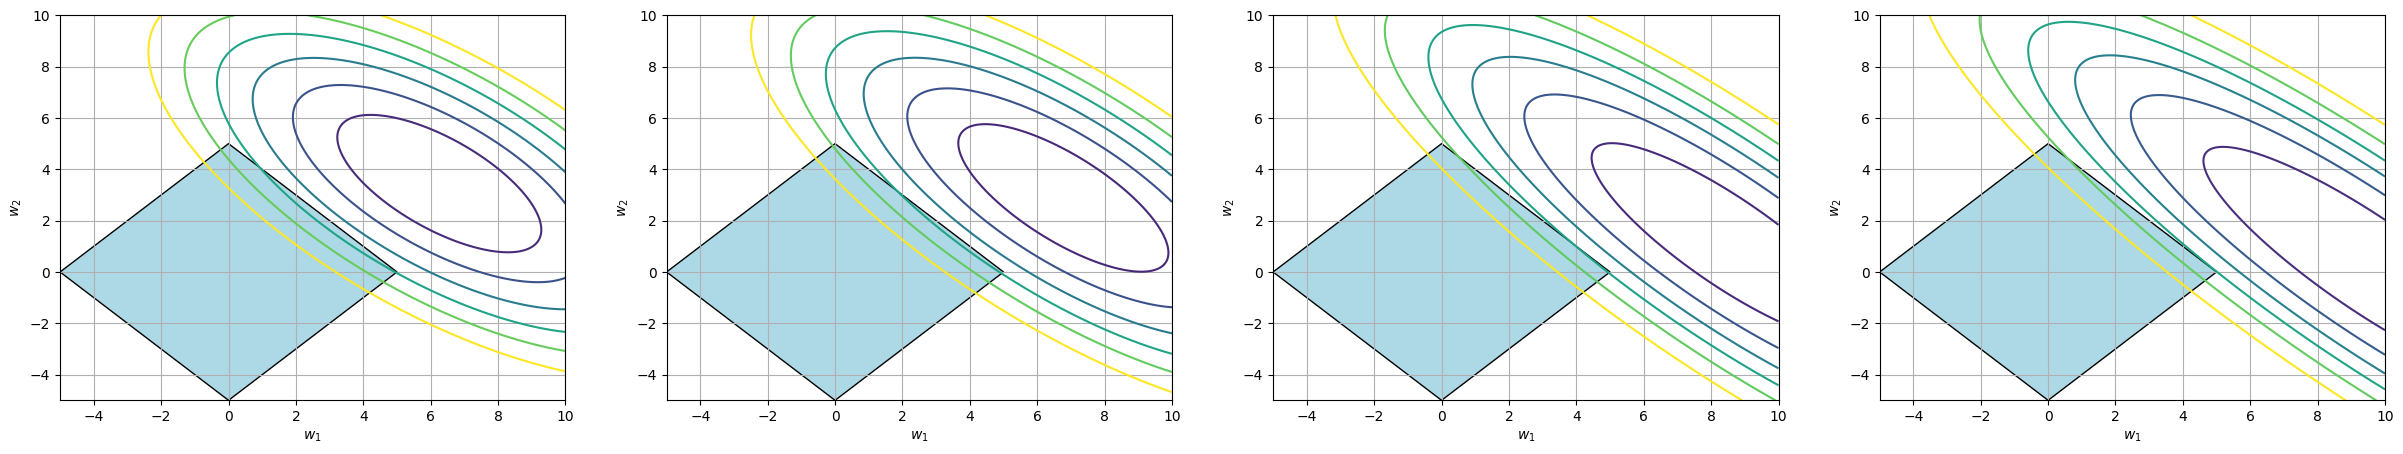

In [ ]:
fig, axes = plt.subplots(1, X.shape[1], figsize=(30, 5))
for i, ax in enumerate(axes):
    diamond = Polygon(
        [(0, 5), (5, 0), (0, -5), (-5, 0)],
        closed=True,
        edgecolor='black',
        facecolor='lightblue'
    )
    draw_loss_contour(
        ax=ax, W0=W[0], W1=W[1], L=MSE[i], conjuction=diamond
    )

For the problems with **low correlation between predictors**, the contour line corresponding to the lowest value of the function that intersects the diamond formed by the conjunction touches the conjunction at an edge - that is, at a point where $w_1 \neq 0$, $w_2 \neq 0$.

For problems with a strong linear relationship between predictors, the MSE takes on a more elliptical shape — the weights can substitute for each other. Geometrically, this leads to the optimal contour line permitted by the conjunction intersecting the diamond at a vertex, i.e., at a point where $w_2 = 0$.

In contrast, the following picture represents an optimization problem with conjunctions formed by the L2 regularization: $w_1^2 + w_2^2 \leq 3$.

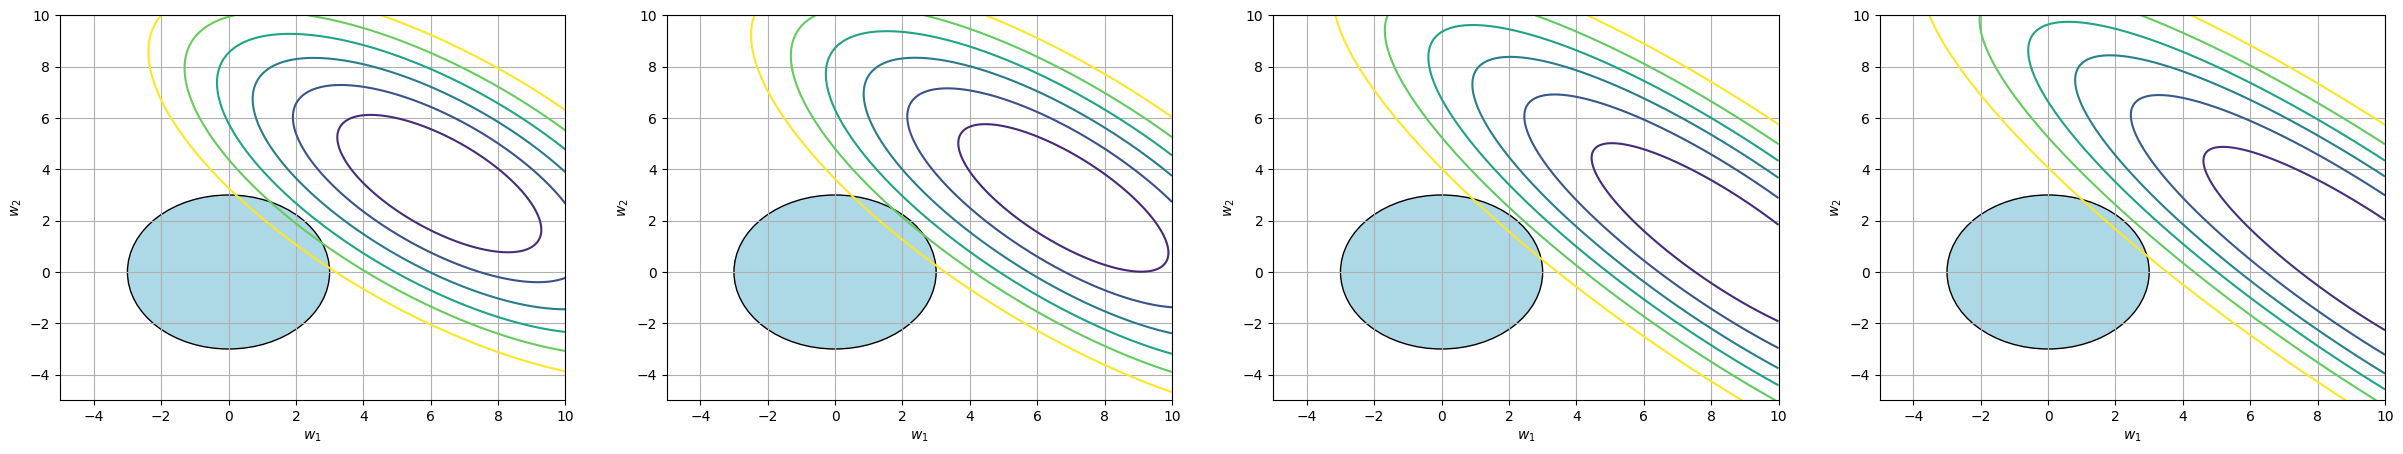

In [ ]:
fig, axes = plt.subplots(1, X.shape[1], figsize=(30, 5))
for i, ax in enumerate(axes):
    circle = Circle(
        (0, 0), 3,
        edgecolor='black',
        facecolor='lightblue'
    )
    draw_loss_contour(
        ax=ax, W0=W[0], W1=W[1], L=MSE[i], conjuction=circle
    )

Regardless of the shape of the MSE function, the solution to the optimization problem lies at a point where both $w_1$ and $w_2$ are non-zero.

### Scaling

It is recommended to scale the data before performing regularisation. In this page I want to show why.

The reason is quite simple - popular components of the target function responsible for regularisation of the model look like this.

- $\sum{\beta_i^2}$;
- $\sum{\left|\beta_i\right|}$.

All coefficients have the same contribution to the target function, regardless of their magnitude, so the optimisation algorithm naturally benefits from reducing first those coefficients that make a greater contribution to the target function, regardless of the economic/physical sense of the variables.

Thus regularisation may compress the coefficients too much at large scales without any intelligible reason for doing so. It is to counteract these phenomena that it is recommended to bring the data to a uniform scale by any available means.

Below is a small experiment that confirms this idea.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

Let's say you have a data frame with two features and their scaling is dramatically different.

So in the following cell I reproduce such a case. There are two functions and the numbers in the first function are usually 100 times smaller than in the second. But on the target variable, they out of order have about the same effect - each unit in the first variable contributes 100 times more to the value of the explained variable.

In [ ]:
np.random.seed(10)
sample_size = 200

X = np.concatenate(
    [
        np.random.normal(1, 0.5, (sample_size, 1)),
        np.random.normal(100, 50, (sample_size, 1))
    ],
    axis = 1
)

y = np.dot(X, np.array([500, 5])) + np.random.normal(0, 10, sample_size)

We will now gradually increase the scaling. Note that the higher scaling coefficient decreases much faster than the second one. Even in relative units:

- $\beta_1(\alpha=0) \approx 2*\beta_1(\alpha=45)$ coefficient with higher scaling became twice as low;
- $\beta_1(\alpha=0) \approx \beta_1(\alpha=45)$ coefficient with lower scaling will decrease a little, but not twice as much as the first coefficient.

In [ ]:
display_frame = pd.DataFrame(
    {alpha:Ridge(alpha = alpha).fit(X,y).coef_ for alpha in np.arange(0, 50, 5)}
).T

display_frame.index.name = "$\\alpha$"
display_frame.columns = ["$\\beta_1$", "$\\beta_2$"]
display(display_frame)

,$\beta_1$,$\beta_2$
$\alpha$,,
0,499.305569,5.029773
5,451.840445,5.012651
10,412.616182,4.998492
15,379.658049,4.986585
20,351.575574,4.976432
25,327.361354,4.967669
30,306.267632,4.960028
35,287.727714,4.953306
40,271.304290,4.947344


Now we want to do the same operation, but with a standardised feature matrix. Display the coefficients you need to multiply with the standardised and original data in different columns.

As the result:

- The coefficients on the standardized data decrease uniformly even in absolute terms;
- If you transform coefficients to be used directly with the original data, because of the difference in scaling, the absolute decrease is greater for the features with higher scaling, but relatively both coefficients decreases ~ 20%.

In [ ]:
means = X.mean(axis=0)
std = X.std(axis = 0)

X_stand = (X-means)/std


display_frame = pd.DataFrame(
    {alpha:Ridge(alpha = alpha).fit(X_stand,y).coef_ for alpha in  np.arange(0, 50, 5)}
).T

display_frame.index.name = "$\\alpha$"
display_frame.columns = ["$\\beta_1$", "$\\beta_2$"]
pd.concat(
    [
        display_frame,
        (display_frame+means)/std
    ],
    keys=["Standardised data", "Original data"],
    axis = 1
)

Standardised data             Original data          
                 $\beta_1$   $\beta_2$     $\beta_1$ $\beta_2$
$\alpha$                                                      
0               243.721886  232.585223    501.430354  7.222430
5               237.582185  226.708414    488.852137  7.095341
10              231.744246  221.121240    476.892129  6.974515
15              226.186353  215.802807    465.505843  6.859501
20              220.888825  210.734182    454.652961  6.749890
25              215.833785  205.898170    444.296855  6.645309
30              211.004954  201.279119    434.404177  6.545419
35              206.387481  196.862749    424.944500  6.449913
40              201.967783  192.636007    415.890002  6.358508
45              197.733422  188.586938    407.215194  6.270944